# Deep learning, but not understanding

CAP 6635 Artifical Intelligence Spring 2021
Christian Garbin

In the book "Artifical Intelligence, a giude for thinking humans" (Melanie Mitchell) explains that

> "Learning in neural networks simply consists in gradually modifying the weights on connections so that each output’s error gets as close to 0 as possible on all training examples."

Is that really "learning"?

Let's explore that idea.

Credit where credit is due: all quoted text comes from Micthell's excellent book.

## An extremely short explanation of deep learning

Deep learning uses layers of "units" (also called "neurons", but some people, including Mitchell and me, prefer the more generic "units" term, to not confuse with actual neurons) to extract patterns from labeled data. The internal layers are called "hidden layers". The last layer is called the "output layer", or the classification layer.

In the following figure (from Mitchell's book), a neural network comprised of several hidden layers (only one shown) was trained to classify handwritten digits. The output layer has ten units, one for each possible digit.

![Neural network](pics/neural-network.png)

## Back to "learning"

> "Learning in neural networks simply consists in gradually modifying the weights on connections so that each output’s error gets as close to 0 as possible on all training examples."

Disentagling the sentence a bit:

- "training examples": the labeled examples we present to the network to train it. For example we present a picture of a square or a triangle and its corresponding label, "square" or "triangle", respectively.
- "output's error": how far the network's prediction is from the correct label of the example picture.
- "weights on connections": a fine-precision decimal number (several digits after the dot) that adjusts the output of a unit in one layer to the input of a neuron in the next layer. The weights is where the "knowledge" of the neural network is encoded.
- "gradually modifying": this is the learning process. An algorithm carefully modifies the weights on the connections to get closer to the expected output. Repeating the adjustment step over time (many, many times) allows the network to learn from the training examples.

An important consequence of this process:

> The machine learns what it observes in the data rather than what you (the human) might observe. If there are statistical associations in the training data, even if irrelevant to the task at hand, the machine will happily learn those instead of what you wanted it to learn.

Thus, neural networks are not "learning" in the sense that we would understand the term. They are not learning higher-level concepts from the samples used to train them. They are extracting patterns from the data presented to them during training (and they assume that the labels are correct). That's all.

Or, as Mitchell puts more eloquently:

> The phrase “barrier of meaning” perfectly captures an idea that has permeated this book: humans, in some deep and essential way, understand the situations they encounter, whereas no AI system yet possesses such understanding. While state-of-the-art AI systems have nearly equaled (and in some cases surpassed) humans on certain narrowly defined tasks, these systems all lack a grasp of the rich meanings humans bring to bear in perception, language, and reasoning. This lack of understanding is clearly revealed by the un-humanlike errors these systems can make; by their difficulties with abstracting and transferring what they have learned; by their lack of commonsense knowledge; and by their vulnerability to adversarial attacks. The barrier of meaning between AI and human-level intelligence still stands today.

Should we be concerend that deep learning is not "learning"? We should, if we don't understand what it implies for real-life applications.

In the next sections we will explore how neural networks lacks the grasp of "rich meanings we humans bring to bear in perception", illustrating it with some "un-humanlike errors these systems can make; by their difficulties with abstracting and transferring what they have learned; by their lack of commonsense knowledge".

## Telling squares and triangles apart

We will see how a neural network trained to tell squares and triangles apart behaves.

For human beings, the pictures below show squares and triangles. Some are upright, some are rotated, some are in a light background, some are in a darker background. But they are all clearly either a square or a triangle in a frame.

![Squares and triangles](pics/squares-triangles.png)


In this section we will go through the typical process of training a neural network:

1. Get a labeled dataset
1. Split the dataset into a training set and a test set
1. Train the network with the training set
1. Validate its accuracy with the test set

After we are done with that, we will predict similar, but not exactly the same, images to see how the network handles them.

First, load some of the frameworks we need and prepare the environment.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import images

%matplotlib inline

# To increase reproducibility (although it's not guaranteed)
# Based on https://stackoverflow.com/a/52897216
seed_value = 0
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
                   
images.create_datasets()             

### The "squares vs. triangles" training examples

Load the square and triangle training examples.

In [2]:
(train_set, train_label), (test_set, test_label) = images.get_upright_dataset(10)
class_names = images.get_class_labels()

This is how the training examples look like. Each picture is a square or a triangle in different positions.

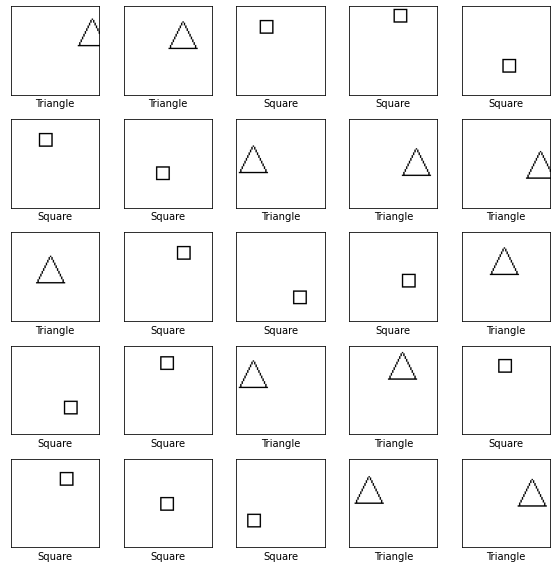

In [3]:
def draw_pictures(pictures, labels, figsize, count, ncols):
    plt.figure(figsize=figsize)
    for i in range(count):
        plt.subplot(count // ncols, ncols, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(pictures[i], cmap='gray')
        if labels is not None:
            plt.xlabel(class_names[labels[i]])
    plt.tight_layout()
    plt.show()

draw_pictures(train_set, train_label, (8,8), 25, 5)

### The "square vs. triangle" neural network

We will now train a neural network to classify a picture as a "square" or as a "triangle", using the training examples.

The code is based on the [TensorFlow classification tutorial](https://www.tensorflow.org/tutorials/keras/classification) and the [TensorFlow CNN classification tutorial](https://www.tensorflow.org/tutorials/images/cnn).

In [4]:
train_set, train_label = images.prepare_set(train_set, train_label)
test_set, test_label = images.prepare_set(test_set, test_label)

In [5]:
INPUT_SHAPE = (images.CANVAS_SIZE, images.CANVAS_SIZE, 1)
NUM_CLASSES = len(class_names)

def get_model():
    """Return a compiled model, ready to be trained."""
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                               input_shape=INPUT_SHAPE),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
    ])
    
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    return model


In [6]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2, verbose=1,
    restore_best_weights=True)

In [7]:
BATCH_SIZE = 64
EPOCHS = 5

model = get_model()
model.fit(train_set, train_label, batch_size=BATCH_SIZE, epochs=EPOCHS,
          validation_data=(test_set, test_label), callbacks=[callback])

Epoch 1/5
10/10 [==============================] - 3s 265ms/step - loss: 1.1562 - accuracy: 0.4473 - val_loss: 0.6914 - val_accuracy: 0.4925
Epoch 2/5
10/10 [==============================] - 2s 237ms/step - loss: 0.6774 - accuracy: 0.5618 - val_loss: 0.6924 - val_accuracy: 0.4925
Epoch 3/5
10/10 [==============================] - 2s 212ms/step - loss: 0.5801 - accuracy: 0.6770 - val_loss: 0.4654 - val_accuracy: 0.8209
Epoch 4/5
10/10 [==============================] - 2s 246ms/step - loss: 0.3118 - accuracy: 0.9256 - val_loss: 0.2652 - val_accuracy: 0.8806
Epoch 5/5
10/10 [==============================] - 2s 249ms/step - loss: 0.1456 - accuracy: 0.9613 - val_loss: 0.1061 - val_accuracy: 0.9701


### How does the neural network perform?

When we loaded the squares and triangles, we set aside 10% of them to use later, as the test set. They are pictures that the neural network was not trained on.

Using the test set, we can measure the performance of the neural network. A traditional measure of performance is "accuracy". It measures the percentange of pictures in the test set correctly classified.

First we ask the neural network to predict what the pictures are (more details on how that happens [here](https://github.com/fau-masters-collected-works-cgarbin/decision-threshold-effect-on-accuracy)).

In [8]:
pred_prob = model.predict(test_set)
pred_label = np.argmax(pred_prob, axis=1)

Now we compare with the actual labels and calculate the accuracy.

In [9]:
pred_correct = pred_label == test_label.flatten()
num_labels = len(test_label)
print('Out of {} pictures, {} were classified correctly'.format
     (num_labels, sum(pred_correct)))
print('Accuracy = {:.1%}'.format(sum(pred_correct) / num_labels))

Out of 67 pictures, 65 were classified correctly
Accuracy = 97.0%


This is a pretty good accuracy for a relatively small network that can be trained quickly.

Let's visualize where the neural network made the mistakes. The picture below shows the mistakes with a red background. All other pictures were classified correctly. Below each picture is the neural network's classification.

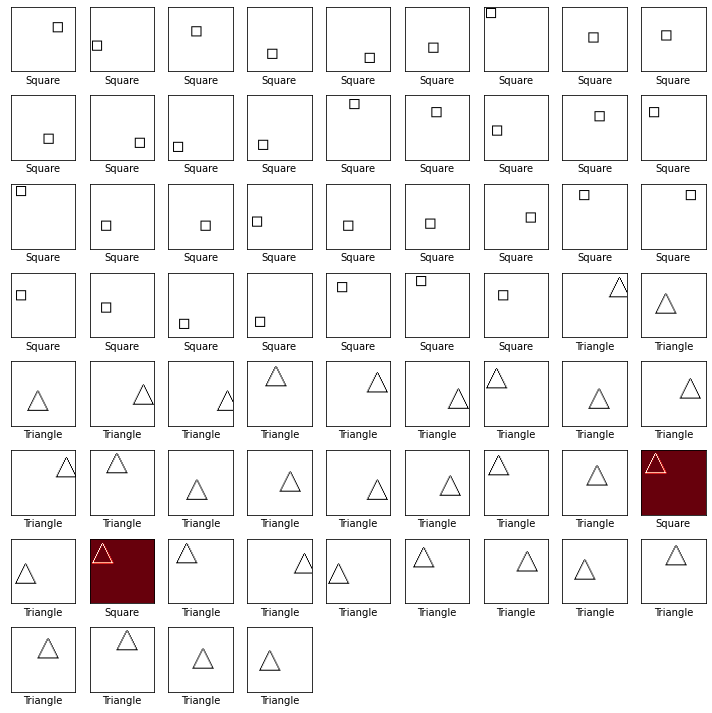

In [10]:
plt.figure(figsize=(10,10))
for i in range(num_labels):
    plt.subplot(8, 9, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    cmap = 'gray' if pred_label[i] == test_label[i][0] else 'Reds'
    plt.imshow(test_set[i], cmap=cmap, vmin=0.0, vmax=1.0)
    plt.xlabel(class_names[pred_label[i]])
plt.tight_layout()
plt.show()

But does the network understand the concept of what it is learning?

## When are squares not squares?

When they are rotated. At least for this neural network.

In this section we will use the neural network we just trained to classify a set of squares. But there is a twiste to these squares: they are rotated by about 45 degreees.

This is how they look like.

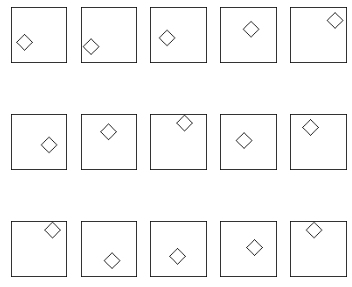

In [11]:
rotated_squares = images.get_square_rotated_dataset()
draw_pictures(rotated_squares, None, (5,5), 15, 5)

Using the neural network, we classify the rotated squares.

In [12]:
rotated_squares, _ = images.prepare_set(rotated_squares)
pred_prob = model.predict(rotated_squares)
pred_label = np.argmax(pred_prob, axis=1)

This is the accuracy of the classification.

In [14]:
pred_correct = pred_label == images.LABEL_SQUARE
num_labels = len(pred_label)
print('Out of {} pictures, {} were classified correctly'.format
     (num_labels, sum(pred_correct)))
print('Accuracy = {:.1%}'.format(sum(pred_correct) / num_labels))

Out of 88 pictures, 23 were classified correctly
Accuracy = 26.1%


That's significantly worse than the accuracy on upright squares.

These are all the squares in this set and how the neural network classified them. The ones with the red(ish) background were incorrectly classified as triangles.

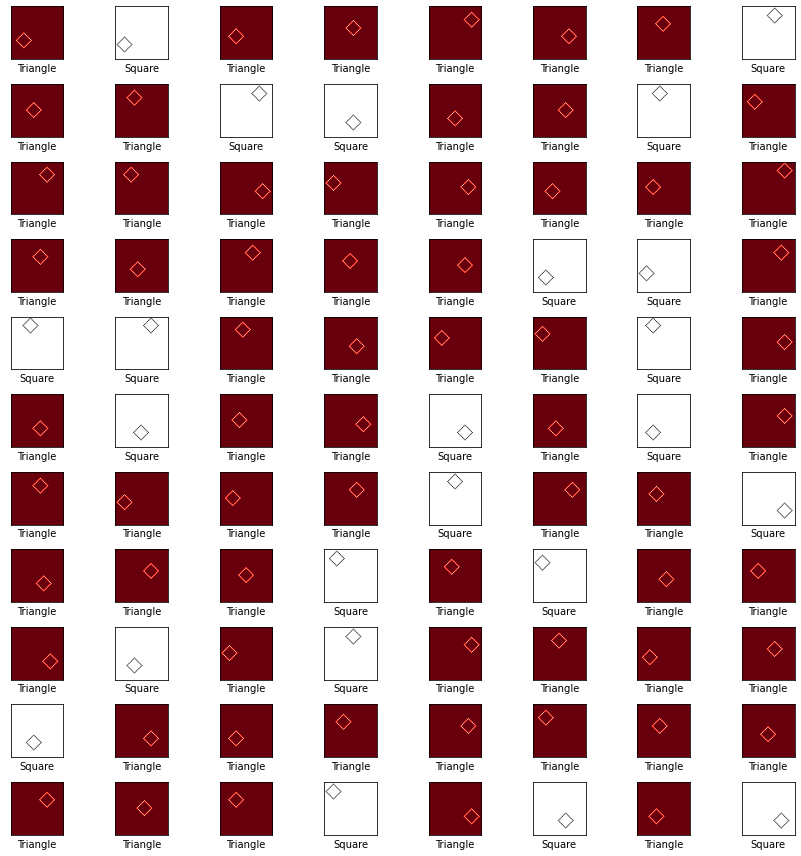

In [17]:
plt.figure(figsize=(12,12))
for i in range(88):
    plt.subplot(11, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    cmap = 'gray' if pred_label[i] == images.LABEL_SQUARE else 'Reds'
    plt.imshow(rotated_squares[i], cmap=cmap, vmin=0.0, vmax=1.0)
    plt.xlabel(class_names[pred_label[i]])
plt.tight_layout()
plt.show()

## Why does this experiment matter?

The simplest and fastest way to improve this neural network is to increase the size of the training and test sets. In this case, we should add rotated squares to the training set and retrain the neural network. It will very likely perform better.

But this does not address the fundamental problem: ***the neural network does not understand the concept of "square".***

Quoting Mitchell again (emphasis added):

> The phrase “barrier of meaning” perfectly captures an idea that has permeated this book: humans, in some deep and essential way, understand the situations they encounter, whereas no AI system yet possesses such understanding. While state-of-the-art AI systems have nearly equaled (and in some cases surpassed) humans on certain narrowly defined tasks, ***these systems all lack a grasp of the rich meanings humans bring to bear in perception, language, and reasoning. This lack of understanding is clearly revealed by the un-humanlike errors these systems can make; by their difficulties with abstracting and transferring what they have learned; by their lack of commonsense knowledge;*** and by their vulnerability to adversarial attacks. The barrier of meaning between AI and human-level intelligence still stands today.

Even if we collect lots and lots and lots of example, we are confronted with ***the long-tail problem***:

> the vast range of possible unexpected situations an AI system could be faced with.

For example, let's say we trained our autonomous driving system to recognize a school zone by the warning sign painted on the road ([source](https://virtualdriveoftexas.com/texas-school-zones/)):

![](pics/school-spelled-right.png)

Then, one day our autonomous driving system comes across these real-life examples (image sources: [1](https://www.anyvan.com/blog/whats-going-on/back-to-shcool-for-some/), [2](https://www.wibw.com/content/news/School-misspelled-at-Florida-crosswalk-508798331.html?ref=331)):

| ![](pics/school-spelled-wrong-1.png) | ![](pics/school-spelled-wrong-2.png) |

Any (well, most) human beings would still identify them as warning signs for school zones (presumably - and hopefully - the human would chuckle, then slow down).

Would the autonomous driving system identify them correctly? The honest answer is "we don't know". It depends on how it was trained. Was it given these examples in the training set? In enough quantities to identify the pattern? Did the test set have examples? Were they classified correctly?

But no matter how comprehensive we make the training and test sets and how methodically we inspect the classification restuls, we are faced with the fundamental problem: ***the neural network does not understand the concept of "school zone warning"***.

The autonomous driving system lacks common sense.

> ...humans also have a fundamental competence lacking in all current AI systems: common sense. We have vast background knowledge of the world, both its physical and its social aspects.

The neural network may be learning, but it is definitely not understanding.

# Telling squares and triangles apart - part 2

In [ ]:
(train_set, train_label), (test_set, test_label) = images.get_color_dataset(10)
class_names = images.get_class_labels()

In [ ]:
train_set, train_label = images.prepare_set(train_set, train_label)
test_set, test_label = images.prepare_set(test_set, test_label)

In [ ]:
print(train_set.shape, train_set.dtype, train_label.shape, train_label.dtype)
print(test_set.shape, test_set.dtype, test_label.shape, test_label.dtype)

In [ ]:
plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_set[i], cmap='gray', vmin=0.0, vmax=1.0)
    plt.xlabel(class_names[train_label[i][0]])
plt.tight_layout()
plt.show()

In [ ]:
model2 = get_model()
model2.fit(train_set, train_label, batch_size=BATCH_SIZE, epochs=EPOCHS,
           validation_data=(test_set, test_label), callbacks=[callback])

In [ ]:
pred_prob = model2.predict(test_set)
pred_label = np.argmax(pred_prob, axis=1)

In [ ]:
plt.figure(figsize=(10,10))
for i in range(67):
    plt.subplot(8,9,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    cmap = 'gray' if pred_label[i] == test_label[i][0] else 'Reds'
    plt.imshow(test_set[i], cmap=cmap, vmin=0.0, vmax=1.0)
    plt.xlabel(class_names[pred_label[i]])
plt.tight_layout()
plt.show()

# In the dark, all squares are triangles

In [ ]:
dark_squares = images.get_square_dark_gray_dataset()
dark_squares, _ = images.prepare_set(dark_squares)

In [ ]:
plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(dark_squares[i], cmap='gray', vmin=0.0, vmax=1.0)
plt.tight_layout()
plt.show()

In [ ]:
pred_prob = model2.predict(dark_squares)
pred_label = np.argmax(pred_prob, axis=1)

In [ ]:
print(pred_label)
print(len(pred_label))

In [ ]:
plt.figure(figsize=(12,12))
for i in range(88):
    plt.subplot(11,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(dark_squares[i], cmap='gray', vmin=0.0, vmax=1.0)
    plt.xlabel(class_names[pred_label[i]])
plt.tight_layout()
plt.show()

## Why does this matter?

>>> Show poor light conditions failures

# Should we be concerned that deep learning is not "learning"?